In [1]:
import jax
import jax.numpy as jnp
import immrax as irx

from fit_params import fit
from functools import partial

# wrap the jax.jit function to set the backend to cpu by default for convenience
device = 'cpu'
def jit (*args, **kwargs):
    kwargs.setdefault('backend', device)
    return jax.jit(*args, **kwargs)

print(jax.devices())

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


[CpuDevice(id=0)]


In [2]:
# Actual System Dynamics
class KinematicBike (irx.System) :
    def __init__(self) -> None:
        self.evolution = 'continuous'
        self.xlen = 4
        self.lr = 5.5*0.6
        self.lf = 5.5*0.4
    def f(self, t:jnp.ndarray, x:jnp.ndarray, u:jnp.ndarray, w:jnp.ndarray) -> jnp.ndarray :
        px, py, psi, v = x[0], x[1], x[2], x[3]
        u1, u2 = u[0], u[1]
        beta = jnp.arctan(self.lr*jnp.tan(u2)/(self.lr+self.lf))
        return jnp.array([
            v*jnp.cos(psi + beta),
            v*jnp.sin(psi + beta),
            (v/self.lr)*jnp.sin(beta),
            u1*(1 - w)
        ])

In [3]:
# Embedding System Dynamics
# custom inclusion function for kinematic bicycle

d_prod = irx.natif(jnp.dot)    
d_sin = irx.natif(jnp.sin)
d_cos = irx.natif(jnp.cos)
d_abs = irx.natif(lambda x: jnp.sqrt(x**2))
d_exp = irx.natif(jnp.exp)
    
    
def F (t, x, u, buffer) :
    px, py, psi, v = x[0], x[1], x[2], x[3]
    a, delta = u[0], u[1]

    
    lr = 5.5*0.6
    lf = 5.5*0.4
    
    beta = jnp.arctan(lr*jnp.tan(delta)/(lr+lf))

    mean = 0.2
    w = irx.interval(mean - buffer, mean + 4 * buffer)

    dx = d_prod(v, d_cos(psi + beta))
    dy = d_prod(v, d_sin(psi + beta))
    dpsi = d_prod(v/lr, d_sin(beta))
    dv = d_prod(a, irx.interval(1) - w)
    # must cast all constants that math with intervals to also be intervals (except division)
    # this is a known issue with the current implementation of immrax that will be difficult to fix

    
    return irx.interval([dx.lower, dy.lower, dpsi.lower, dv.lower], 
                        [dx.upper, dy.upper, dpsi.upper, dv.upper])

In [4]:
# BEGIN MPC PROBLEM
from cyipopt import minimize_ipopt

# PARAMETERS
dt = 0.1 # time step
t0 = 0. # initial time
th = 1.5 # horizon time
N = round((th - t0)/dt) + 1 # number of time steps
tt = jnp.arange(t0, th + dt, dt) # time vector
# buffer_list = jnp.array([0.319, 0.674, 1.15, 2.576]) # represents, 0.25, 0.5, 0.75, 0.99 probability bounds
# buffer_list = jnp.array([0.426, 0.954, 2.576]) # represents, 0.33, 0.66, 0.99 probability bounds
# prob_list = buffer_list

# full distribution
buffer_list = jnp.array([0.025, 0.05, 0.075, 0.1]) # hardcoded values
prob_list = jnp.array([0.25, 0.5, 0.75, 1.0]) # hardcoded values

# conservative
# buffer_list = jnp.array([0.1]) # hardcoded values
# prob_list = jnp.array([1.0]) # hardcoded values

# reckless
# buffer_list = jnp.array([0.025]) # hardcoded values
# prob_list = jnp.array([0.25]) # hardcoded values

print(len(buffer_list))

# list of obstacles in [x_lower, y_lower, x_upper, y_upper] format
# obstacles = jnp.array([[1.5, 1., 3., 3.],
#                        [1., -3, 3, -1],
#                        [5., 6, 6, 7],
#                        [5., -1, 6, 1]])
obstacles = jnp.array([[5., -5., 6., 5.]])
                    #    [0., -6., 8., -5.]])

# goal region in [x_lower, y_lower, x_upper, y_upper] format
# goal = jnp.array([3.75, -0.5, 4.75, 0.5]) # initial
goal = jnp.array([3.9, -0.5, 4.9, 0.5])

x0_t = jnp.array([2., -0.05, 0., 0., 2.1, 0.05, 0., 0.]) # initial state of embedding system

4


In [5]:
# Create embedding system
kinbike = KinematicBike()
KBGPEMB = irx.ifemb(kinbike, F)

# initialize input vector
u0_t = jnp.zeros((N, 2)).reshape(-1)
print(u0_t)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]


In [6]:
# Function to rollout the undisturbed dynamics using Euler integration
@jit
def rollout_ol_sys_undisturbed (u:jax.Array, xinit:jax.Array, buffer:jax.float0) -> jax.Array :
    # xinit = u[:8] # initial state
    # obs = u[8:17].reshape(-1, 3) # observation points
    # u = u[17:].reshape(-1, 2) # inputs

    # print(xinit)
    # print(obs)

    def f_euler (xt, ut) :
        xtp1 = xt + dt*KBGPEMB.f(0., xt, ut, buffer)
        return (xtp1, xtp1)
    _, x = jax.lax.scan(f_euler, xinit, u.reshape(-1, 2))
    # print(x)
    return x

@jit
def distribution_rollout(u:jax.Array, xinit:jax.Array) -> jax.Array :
    x = jnp.zeros((len(buffer_list), N, 8))
    for i, buffer in enumerate(buffer_list):
        x = x.at[i, :, :].set(rollout_ol_sys_undisturbed(u, xinit, buffer))
    return x

# compares two embedding system states to see if southeast order is preserved
def SE_order(xin, yin):
    if xin.ndim == 1 and yin.ndim == 1:
        half_index = int(xin.size/2)
        # print(half_index)

        # separate x and xhat (NOT lower and upper bounds, as we need to be able to check intersection as well)
        x = xin[0:half_index]
        xhat = xin[half_index:]
        y = yin[0:half_index]
        yhat = yin[half_index:]
    elif xin.ndim == 2 and yin.ndim == 2:
        half_index = int(xin.shape[1]/2)

        # separate x and xhat (NOT lower and upper bounds, as we need to be able to check intersection as well)
        x = xin[:,0:half_index]
        xhat = xin[:,half_index:]
        y = yin[:,0:half_index]
        yhat = yin[:,half_index:]
    else:
        raise ValueError("Input dimensions do not match")

    # returns all positive values if SE order preserved (i.e. y is contained in x)
    val = jnp.array([y - x, xhat-yhat])
    se = jnp.all(val >= 0) # single boolean value, is SE order preserved (yes/no)?

    return se, val

def intersection(x, y):
    half_index = int(y.size/2)
    y_end = y[0:half_index]
    y = y.at[0:half_index].set(y[half_index:])
    y = y.at[half_index:].set(y_end)
    # print(x, y)
    se, val = SE_order(x, y)
    # print(val)
    # print(jnp.min(val, axis=0))

    # returns 0 if no intersection, otherwise returns intersection area
    return jnp.max(jnp.array([0, (-1 + 2*se)*jnp.abs(jnp.prod(jnp.min(val, axis=0)))])) 

# test intersection (should return 0.25)
x = jnp.array([1., 2., 2.5, 3.])
y = jnp.array([2., 1., 3., 2.5])
print(intersection(x, y))

# test intersection (should return 0)  
x = jnp.array([1., 2., 2.5, 3.])
y = jnp.array([3., 1., 4., 2.5])
print(intersection(x, y))

x = jnp.array([2.876, -1.326, 5.737,  0.469])
y = obstacles[0, :]
print(intersection(x, y))

x = jnp.array([2.876, -1.326, 5.737,  0.469])
y = goal
print(intersection(x, y))

0.25
0.0
4.030653
1.7800529


In [7]:
# DEFINE COST/OBJECTIVE FUNCTION (MINIMIZE)
@jit
def obj (u:jax.Array, xinit:jax.Array) -> jax.Array :
    # x = compute_traj(u)
    x = distribution_rollout(u, xinit)
    # return -1 * jnp.sum(x[:,:,0] + (x[:,:,4] - x[:,:,0])/2.) # for now, just want to move right as far as possible
    # new cost function: get to goal, while avoiding obstacles, weight reward/punishment based on reachable set probability & amount of intersection
    
    # initialize as distance to goal
    centers = x[:, :, [0, 1]] + (x[:, :, [4, 5]] - x[:, :, [0, 1]])/2.
    goal_center = goal[0:2] + (goal[2:] - goal[0:2])/2.
    val = 0.005 * jnp.sum(jnp.linalg.norm(goal_center - centers, 2, axis=2))

    # check for intersections with obstacles and goal
    for i in range(x.shape[0]):
        prob = prob_list[i]
        for j in range(x.shape[1]):
            # pull from x and flip to check intersections
            # rect = x[i, j, [4, 5, 0, 1]]
            # jk don't flip
            rect = x[i, j, [0, 1, 4, 5]]
            area = (rect[2] - rect[0])*(rect[3] - rect[1])
            # print(rect)
            # check obstacles
            for o in range(obstacles.shape[0]):
                # punish for intersection with obstacles
                val += 10 * prob * intersection(rect, obstacles[o, :])/area
                
            # check goal, reward for intersection
            val += -10 * prob * intersection(rect, goal)/area
    print("COMPILED")
    return val
    

# DEFINE EQUALITY CONSTRAINT FUNCTION (CURRENTLY UNUSED)
def constraint_function (u, x, w) :
    return irx.norm(x, 2) + irx.norm(u, 2) + irx.norm(w, 2)

# DEFINE INEQUALITY CONSTRAINT FUNCTION (POSITIVE VALUES INDICATE FULFILLMENT)
@jit
def con_ineq (u, xinit):
    # x = compute_traj(u)
    x = distribution_rollout(u, xinit)
    # print(x)
    # result = jnp.hstack([preserve_order(x), avoid_obstacles(x)])
    result = preserve_order(x)
    return result

def preserve_order(x):
    diff = x[:, :, 4:] - x[:, :, :4]
    return diff.reshape(-1)

# if avoiding obstacles is a requirement, then this function should be used
def avoid_obstacles(x):
    result = []
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            for k in range(obstacles.shape[0]):
            

                # check if the southeast order is preserved when obstacle is flipped
                # print(x[i, [0, 1, 4, 5]], obstacles[j, [2, 3, 0, 1]])
                # _, val = SE_order(jnp.array(x[i, [0, 1, 4, 5]]), jnp.array(obstacles[j, [2, 3, 0, 1]]))
                val = intersection(x[i, j, [0, 1, 4, 5]], obstacles[k, :])
                # print(val)
                # if all positive, then intersection is happening, so multiply by -1 to match inequality constraint requirements
                result.append(-1. * jnp.min(val))
    return jnp.array(result).reshape(-1)

print(obj(u0_t, x0_t))

COMPILED
0.752


In [8]:
# DEFINE MPC PROBLEM
obj_grad = jit(jax.grad(obj, argnums=0))  # Objective Gradient
obj_hess = jit(jax.jacfwd(jax.jacrev(obj, argnums=0), argnums=0))  # Objective Hessian
con_ineq_jac = jit(jax.jacfwd(con_ineq, argnums=0))  # Constraint Jacobian
con_ineq_hess = jit(jax.jacfwd(jax.jacrev(con_ineq, argnums=0), argnums=0)) # Constraint Hessian



# Constraint Hessian-Vector Product
@jit
def con_ineq_hessvp (u, v, xinit) :
    def hessvp (u) :
        _, hvp = jax.vjp(con_ineq, u, xinit)
        return hvp(v)[0] # One tangent, one output. u^T dc_v
    return jax.jacrev(hessvp)(u) 

In [9]:
# print('JIT Compiling Autodiff Functions...')
# from time import time
# time0 = time()

# obj(u0_t, x0_t, obs_t)  # run once to compile
# obj_grad(u0_t, x0_t, obs_t)
# obj_hess(u0_t, x0_t, obs_t)
# con_ineq(u0_t, x0_t, obs_t)
# con_ineq_jac(u0_t, x0_t, obs_t)
# # con_ineq_hessvp(u0_t, jnp.ones(4*N), x0_t, obs_t)
# timef = time()
# print(f'Finished JIT Compiling Autodiff Functions in {timef - time0} seconds')

In [10]:
# This block is just to run the optimization program once to compile all the jax functions

# IPOPT SETTINGS
ipopt_opts = {
    b'disp': 5, 
    b'linear_solver': 'ma97', #formerly ma57, supposedly ma97 works better for large problems 
    b'hsllib': 'libcoinhsl.so', 
    b'tol': 1e-4,
    b'max_iter': 30000,
}

# # TEST: try a version without using partial (nope still recompiles things)
# ineq_fun = lambda u: con_ineq(u, xinit=x0_t, obs=obs_t)
# ineq_jac = lambda u: con_ineq_jac(u, xinit=x0_t, obs=obs_t)
# ineq_hessvp = lambda u, v: con_ineq_hessvp(u, v, xinit=x0_t, obs=obs_t)

# obj_fun = lambda u: obj(u, xinit=x0_t, obs=obs_t)
# obj_grad_fun = lambda u: obj_grad(u, xinit=x0_t, obs=obs_t)
# obj_hess_fun = lambda u: obj_hess(u, xinit=x0_t, obs=obs_t)

# Constraints
bnds = [(-10.,10.) if i % 2 == 0 else (-1.5, 1.5) for i in range(u0_t.size)]
print(bnds)
cons = [ {'type': 'ineq', 'fun': partial(con_ineq, xinit=x0_t), 'jac': partial(con_ineq_jac, xinit=x0_t), 'hess': partial(con_ineq_hessvp, xinit=x0_t)}, ]
# cons = [ {'type': 'ineq', 'fun': ineq_fun, 'jac': ineq_jac, 'hess': ineq_hessvp}, ]
# a_bnds = [(-5.,15.) for _ in range(N)]
# theta_bnds = [(-0.5,0.5) for _ in range(N)]
# bnds = jnp.hstack([a_bnds, theta_bnds]).reshape(-1)
# print(a_bnds)

# Solve the optimization problem (first run still compiles some functions, so it will be slow, still trying to figure out why...)
res = minimize_ipopt(partial(obj, xinit=x0_t), jac=partial(obj_grad, xinit=x0_t), hess=partial(obj_hess, xinit=x0_t), x0=u0_t,
                     bounds=bnds, constraints=cons, options=ipopt_opts)
# res = minimize_ipopt(obj_fun, jac=obj_grad_fun, hess=obj_hess_fun, x0=u0_t,
                        # bounds=bnds, constraints=cons, options=ipopt_opts)

print(res)

[(-10.0, 10.0), (-1.5, 1.5), (-10.0, 10.0), (-1.5, 1.5), (-10.0, 10.0), (-1.5, 1.5), (-10.0, 10.0), (-1.5, 1.5), (-10.0, 10.0), (-1.5, 1.5), (-10.0, 10.0), (-1.5, 1.5), (-10.0, 10.0), (-1.5, 1.5), (-10.0, 10.0), (-1.5, 1.5), (-10.0, 10.0), (-1.5, 1.5), (-10.0, 10.0), (-1.5, 1.5), (-10.0, 10.0), (-1.5, 1.5), (-10.0, 10.0), (-1.5, 1.5), (-10.0, 10.0), (-1.5, 1.5), (-10.0, 10.0), (-1.5, 1.5), (-10.0, 10.0), (-1.5, 1.5), (-10.0, 10.0), (-1.5, 1.5)]

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

COMPILED
 message: b'Maximum number of iterations exceeded (can be specified by an option).'
 success: False
  status: -1
     fun: -421.1829833984375
       x: [ 9

(4, 16, 8)


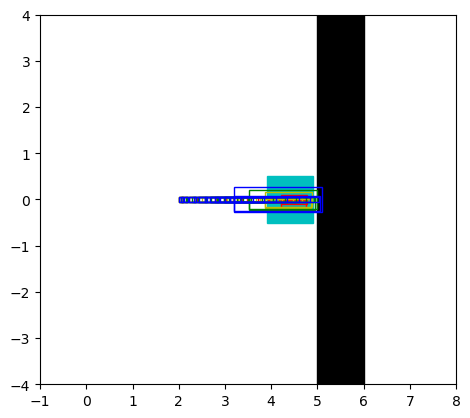

In [11]:
# Graph the resulting trajectory hyperrectangles
import matplotlib.pyplot as plt

x = distribution_rollout(res.x, xinit=x0_t)
print(x.shape)

fig, ax = plt.subplots()
for o in range(obstacles.shape[0]):
    ax.add_patch(plt.Rectangle((obstacles[o, 0], obstacles[o, 1]), obstacles[o, 2] - obstacles[o, 0], obstacles[o, 3] - obstacles[o, 1], facecolor='k', edgecolor='k', label='_nolegend_'))
ax.add_patch(plt.Rectangle((goal[0], goal[1]), goal[2] - goal[0], goal[3] - goal[1], facecolor='c', edgecolor='c', label='_nolegend_')) # nolegend label is workaround to get tikz plot working
colors = ['r', 'y', 'g', 'b']
for i in range(0, x.shape[0]):
    for j in range(0, x.shape[1]):
        ax.add_patch(plt.Rectangle((x[i, j, 0], x[i, j, 1]), x[i, j, 4] - x[i, j, 0], x[i, j, 5] - x[i, j, 1], fill=None, edgecolor=colors[i], label='_nolegend_'))
ax.set_aspect('equal')
ax.set_xlim(-1, 8)
ax.set_ylim(-4, 4)
plt.show()


In [12]:
x0_sim = jnp.array([1.0, -2.01, 0., 0., 1.01, -2.0, 0., 0.]) # initial state of embedding system
u0_sim = jnp.zeros((N, 2)).reshape(-1)
# solve for optimal control strategy
bnds = [(-10.,10.) if i % 2 == 0 else (-1.5, 1.5) for i in range(u0_t.size)]
cons = [ {'type': 'ineq', 'fun': partial(con_ineq, xinit=x0_sim), 'jac': partial(con_ineq_jac, xinit=x0_sim), 'hess': partial(con_ineq_hessvp, xinit=x0_sim)}, ]
res = minimize_ipopt(partial(obj, xinit=x0_sim), jac=partial(obj_grad, xinit=x0_sim), hess=partial(obj_hess, xinit=x0_sim), x0=u0_sim,
                     bounds=bnds, constraints=cons, options=ipopt_opts)

# USE THIS BLOCK FOR TIMING PURPOSES

 message: b'Maximum number of iterations exceeded (can be specified by an option).'
 success: False
  status: -1
     fun: -44.82188415527344
       x: [ 9.997e+00  0.000e+00 ...  0.000e+00 -1.500e+00]
     nit: 30000
    info:     status: -1
                   x: [ 9.997e+00  0.000e+00 ...  0.000e+00 -1.500e+00]
                   g: [ 1.000e-02  1.000e-02 ...  7.074e-01  4.768e+00]
             obj_val: -44.82188415527344
              mult_g: [-6.665e-02 -6.665e-02 ...  1.071e-01 -1.505e-02]
            mult_x_L: [ 3.333e-05  4.443e-04 ...  6.665e-05  4.884e+00]
            mult_x_U: [ 2.556e-01  4.443e-04 ...  6.665e-05  2.222e-04]
          status_msg: b'Maximum number of iterations exceeded (can be specified by an option).'
    nfev: 194624
    njev: 29660
[[ 9.99724584e+00  0.00000000e+00]
 [ 9.96334318e+00  9.60030523e-01]
 [ 9.75490306e+00  9.25607867e-01]
 [ 9.39075457e+00  8.65033803e-01]
 [ 8.93361387e+00  7.75171690e-01]
 [ 7.82541919e+00  6.69910158e-01]
 [ 1.06863020e-02

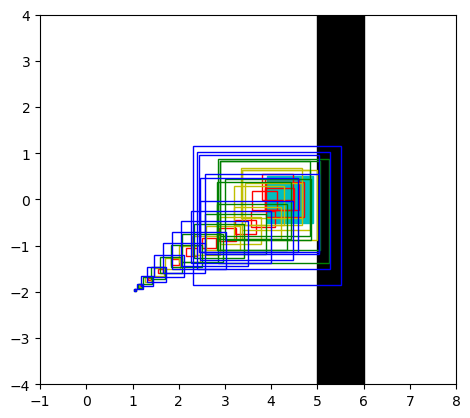

In [13]:
import tikzplotlib
# note: must have webcolors version 1.13 or this breaks

x = distribution_rollout(res.x, xinit=x0_sim)
print(res)
print(res.x.reshape(-1, 2))
print(x)

fig, ax = plt.subplots()
for o in range(obstacles.shape[0]):
    ax.add_patch(plt.Rectangle((obstacles[o, 0], obstacles[o, 1]), obstacles[o, 2] - obstacles[o, 0], obstacles[o, 3] - obstacles[o, 1], facecolor='k', edgecolor='k', label='_nolegend_'))
ax.add_patch(plt.Rectangle((goal[0], goal[1]), goal[2] - goal[0], goal[3] - goal[1], facecolor='c', edgecolor='c', label='_nolegend_'))
for i in range(0, x.shape[0]):
    for j in range(0, x.shape[1]):
        ax.add_patch(plt.Rectangle((x[i, j, 0], x[i, j, 1]), x[i, j, 4] - x[i, j, 0], x[i, j, 5] - x[i, j, 1], fill=None, edgecolor=colors[i], label='_nolegend_'))
ax.set_xlim(-1, 8)
ax.set_ylim(-4, 4)
ax.set_aspect('equal')
plt.show()

# tikzplotlib.save("fig/strategy_full.tex") # save as tikz file (CANNOT CALL PLT.SHOW BEFORE THIS IF YOU WANT TO SAVE PROPERLY)

In [14]:
def rollout_ol_sys (xinit, u, dist):
    def kbf_euler (xt, ut) :
        # print(ut)
        xtp1 = xt + dt*kinbike.f(0., xt, ut, dist)
        return (xtp1, xtp1)
    _, x = jax.lax.scan(kbf_euler, xinit, u)
    # print(x)
    return x

def calculate_friction(fr):
    # turns fr into a uniform dist in [-1, 1)
    factor = (fr - 0.5) * 2
    if factor > 0:
        shift = 0.4 * factor
    else:
        shift = 0.1 * factor

    return 0.2 + shift

[[ 9.99724584e+00  0.00000000e+00]
 [ 9.96334318e+00  9.60030523e-01]
 [ 9.75490306e+00  9.25607867e-01]
 [ 9.39075457e+00  8.65033803e-01]
 [ 8.93361387e+00  7.75171690e-01]
 [ 7.82541919e+00  6.69910158e-01]
 [ 1.06863020e-02  5.50630069e-01]
 [ 6.12729424e-05  4.03722033e-01]
 [ 3.36254398e-02  2.94021992e-01]
 [-2.25189219e-02  2.16145991e-01]
 [-3.05742737e+00  1.71584594e-01]
 [-9.29345693e+00  1.34691301e+00]
 [-9.61592897e+00 -4.92382505e-01]
 [-9.32777134e+00  1.46556665e+00]
 [-8.13700758e+00 -1.49993006e+00]
 [ 0.00000000e+00 -1.49984398e+00]]


(array([  0., 495., 103., 134., 145., 123.,   0.,   0.,   0.,   0.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

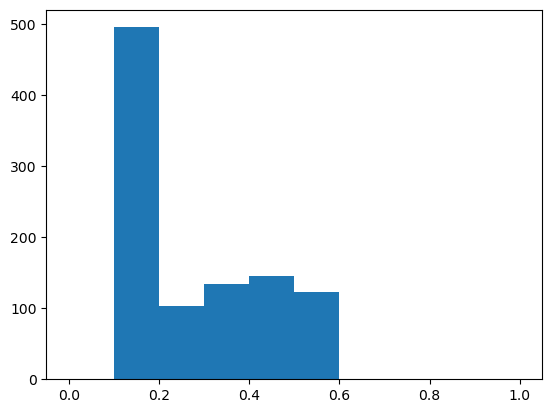

In [15]:
# monte carlo simulation
import numpy as np

num_trials = 1000
seed = 269 # keep this the same for each case to ensure fairness
np.random.seed(seed)

# returns uniform distribution over [0, 1)
trial_vals = np.random.rand(num_trials, 5)
# print(trial_vals)

x_diff = x0_sim[4:] - x0_sim[:4]
# print(x_diff)

# reshape selected inputs
u_res = res.x.reshape(-1, 2)
print(u_res)
goal_count = 0
obs_count = 0

# for debugging
fd_arr = []
endpoints = np.array([])
endpoint_colors = []
colors = ['r', 'y', 'g', 'b']

for xr0, xr1, xr2, xr3, fr in trial_vals:
    # xr0-xr3 determine starting state
    x0_monte = x0_sim[:4] + jnp.multiply(jnp.array([xr0, xr1, xr2, xr3]), x_diff)
    # print(x0_monte)

    # fr determines actual friction coefficient
    fd = calculate_friction(fr)
    fd_arr.append(fd)

    # run system with calculated inputs
    # print(res.x)
    x_result = rollout_ol_sys(jnp.array(x0_monte), jnp.array(u_res), fd)
    # print(x_result[-1, :])
    endpoints = np.vstack([endpoints, x_result[-1, :]]) if endpoints.size else x_result[-1, :]

    # determine endpoint color based on buffer predictions
    for i, buffer in enumerate(buffer_list):
        if fd >= 0.2 - buffer and fd <= 0.2 + 4 * buffer:
            endpoint_colors.append(colors[i])
            break

    if len(endpoint_colors) < len(fd_arr):
        endpoint_colors.append('tab:gray')

    # check if any of the resulting states hit the goal region
    for rect in x_result:
        inter_rect = np.array([rect[0], rect[1], rect[0], rect[1]])
        se, _ = SE_order(goal, inter_rect) # check if inter rect is in goal
        if se:
            # print("Goal Reached")
            goal_count += 1
            break

    # check if any of the resulting states hit the obstacle
    if np.any([x_result[:, 0] > 5]):
        # print("Obstacle Hit")
        obs_count += 1


plt.hist(fd_arr, bins=10, range=(0, 1))



Goal Count:  651
Obstacle Count:  0


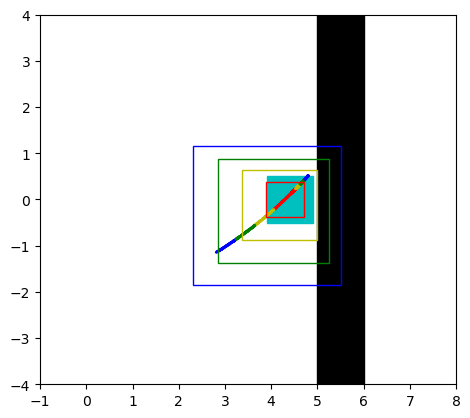

In [16]:
# collate results
print("Goal Count: ", goal_count)
print("Obstacle Count: ", obs_count)

fig, ax = plt.subplots()
for o in range(obstacles.shape[0]):
    ax.add_patch(plt.Rectangle((obstacles[o, 0], obstacles[o, 1]), obstacles[o, 2] - obstacles[o, 0], obstacles[o, 3] - obstacles[o, 1], facecolor='k', edgecolor='k', label='_nolegend_'))
ax.add_patch(plt.Rectangle((goal[0], goal[1]), goal[2] - goal[0], goal[3] - goal[1], facecolor='c', edgecolor='c', label='_nolegend_'))
# ax.plot(x_result[:, 0], x_result[:, 1], c=endpoint_colors[-1])
ax.scatter(endpoints[:, 0], endpoints[:, 1], c=endpoint_colors, s=1)
for i in range(0, x.shape[0]):
    ax.add_patch(plt.Rectangle((x[i, -1, 0], x[i, -1, 1]), x[i, -1, 4] - x[i, -1, 0], x[i, -1, 5] - x[i, -1, 1], fill=None, edgecolor=colors[i], label='_nolegend_'))
ax.set_xlim(-1, 8)
ax.set_ylim(-4, 4)
ax.set_aspect('equal')
plt.show()

# tikzplotlib.save("fig/endpoints_full.tex")

Results

Full Distribution
- Goal Count:  651
- Obstacle Count:  0
- Time: 527 sec.

Conservative
- Goal Count:  580
- Obstacle Count:  0
- Time: 162 sec.

Reckless
- Goal Count:  719
- Obstacle Count: 256 
- Time: 154 sec.